In [1]:
%matplotlib inline


# Spectral analysis of extended sources

Perform a spectral analysis of an extended source.

## Prerequisites

-  Understanding of spectral analysis techniques in classical Cherenkov
   astronomy.
-  Understanding the basic data reduction and modeling/fitting processes
   with the gammapy library API as shown in the tutorial :doc:`/tutorials/starting/analysis_2`

## Context

Many VHE sources in the Galaxy are extended. Studying them with a 1D
spectral analysis is more complex than studying point sources. One often
has to use complex (i.e. non circular) regions and more importantly, one
has to take into account the fact that the instrument response is non
uniform over the selectred region. A typical example is given by the
supernova remnant RX J1713-3935 which is nearly 1 degree in diameter.
See the [following
article](https://ui.adsabs.harvard.edu/abs/2018A%26A...612A...6H/abstract)_.

**Objective: Measure the spectrum of RX J1713-3945 in a 1 degree region
fully enclosing it.**

## Proposed approach

We have seen in the general presentation of the spectrum extraction for
point sources (see :doc:`/tutorials/analysis-1d/spectral_analysis`
tutorial) that Gammapy uses specific
datasets makers to first produce reduced spectral data and then to
extract OFF measurements with reflected background techniques: the
`~gammapy.makers.SpectrumDatasetMaker` and the
`~gammapy.makers.ReflectedRegionsBackgroundMaker`. However if the flag
`use_region_center` is not set to `False`, the former simply
computes the reduced IRFs at the center of the ON region (assumed to be
circular).

This is no longer valid for extended sources. To be able to compute
average responses in the ON region, we can set
`use_region_center=False` with the
`~gammapy.makers.SpectrumDatasetMaker`, in which case the values of
the IRFs are averaged over the entire region.

In summary we have to:

-  Define an ON region (a `~regions.SkyRegion`) fully enclosing the
   source we want to study.
-  Define a `~gammapy.maps.RegionGeom` with the ON region and the
   required energy range (beware in particular, the true energy range).
-  Create the necessary makers :

   -  the spectrum dataset maker :
      `~gammapy.makers.SpectrumDatasetMaker` with
      `use_region_center=False`
   -  the OFF background maker, here a
      `~gammapy.makers.ReflectedRegionsBackgroundMaker`
   -  and usually the safe range maker :
      `~gammapy.makers.SafeMaskMaker`

-  Perform the data reduction loop. And for every observation:

   -  Produce a spectrum dataset
   -  Extract the OFF data to produce a
      `~gammapy.datasets.SpectrumDatasetOnOff` and compute a safe
      range for it.
   -  Stack or store the resulting spectrum dataset.

-  Finally proceed with model fitting on the dataset as usual.

Here, we will use the RX J1713-3945 observations from the H.E.S.S. first
public test data release. The tutorial is implemented with the
intermediate level API.

## Setup

As usual, we’ll start with some general imports…


In [2]:
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

## Check setup



In [3]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/gamma/anaconda3/envs/gammapy-1.0/bin/python 
	python_version         : 3.9.15     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.0.1      
	path                   : /home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.23.5     
	scipy                  : 1.9.1      
	astropy                : 5.1.1      
	regions                : 0.6        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.4.0      
	jupyterlab             : 3.4.8      
	matplotlib             : 3.6.2      
	pandas                 : 1.5.0      
	healpy                 : 1.16.1     
	iminuit                : 2.17.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      


Gammapy en

## Select the data

We first set the datastore and retrieve a few observations from our
source.




In [4]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [20326, 20327, 20349, 20350, 20396, 20397]
# In case you want to use all RX J1713 data in the HESS DR1
# other_ids=[20421, 20422, 20517, 20518, 20519, 20521, 20898, 20899, 20900]

observations = datastore.get_observations(obs_ids)

## Prepare the datasets creation




### Select the ON region

Here we take a simple 1 degree circular region because it fits well with
the morphology of RX J1713-3945. More complex regions could be used
e.g. `~regions.EllipseSkyRegion` or `~regions.RectangleSkyRegion`.




In [5]:
target_position = SkyCoord(347.3, -0.5, unit="deg", frame="galactic")
radius = Angle("0.5 deg")
on_region = CircleSkyRegion(target_position, radius)

### Define the geometries

This part is especially important. - We have to define first energy
axes. They define the axes of the resulting
`~gammapy.datasets.SpectrumDatasetOnOff`. In particular, we have to be
careful to the true energy axis: it has to cover a larger range than the
reconstructed energy one. - Then we define the region geometry itself
from the on region.




In [6]:
# The binning of the final spectrum is defined here.
energy_axis = MapAxis.from_energy_bounds(0.1, 40.0, 10, unit="TeV")

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 30, unit="TeV", name="energy_true"
)

geom = RegionGeom(on_region, axes=[energy_axis])

### Create the makers

First we instantiate the target `~gammapy.datasets.SpectrumDataset`.




In [7]:
dataset_empty = SpectrumDataset.create(
    geom=geom,
    energy_axis_true=energy_axis_true,
)

Now we create its associated maker. Here we need to produce, counts,
exposure and edisp (energy dispersion) entries. PSF and IRF background
are not needed, therefore we don’t compute them.

**IMPORTANT**: Note that `use_region_center` is set to `False`. This
is necessary so that the `~gammapy.makers.SpectrumDatasetMaker`
considers the whole region in the IRF computation and not only the
center.




In [8]:
maker = SpectrumDatasetMaker(
    selection=["counts", "exposure", "edisp"], use_region_center=False
)

Now we create the OFF background maker for the spectra. If we have an
exclusion region, we have to pass it here. We also define the safe range
maker.




In [9]:
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

## Perform the data reduction loop.

We can now run over selected observations. For each of them, we: -
create the `~gammapy.datasets.SpectrumDataset` - Compute the OFF via
the reflected background method and create a
`~gammapy.datasets.SpectrumDatasetOnOff` object - Run the safe mask
maker on it - Add the `~gammapy.datasets.SpectrumDatasetOnOff` to the
list.




In [10]:
datasets = Datasets()

for obs in observations:
    # A SpectrumDataset is filled in this geometry
    dataset = maker.run(dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs)

    # Define safe mask
    dataset = safe_mask_maker.run(dataset, obs)

    # Compute OFF
    dataset = bkg_maker.run(dataset, obs)

    # Append dataset to the list
    datasets.append(dataset)

display(datasets.meta_table)

NAME,TYPE,TELESCOP,OBS_ID,OBS_MODE,RA_PNT,DEC_PNT
,,,,,deg,deg
str9,str20,str4,int64,str8,float64,float64
obs-20326,SpectrumDatasetOnOff,HESS,20326,POINTING,259.29851667325,-39.762222222222
obs-20327,SpectrumDatasetOnOff,HESS,20327,POINTING,257.47731666009,-39.762222222222
obs-20349,SpectrumDatasetOnOff,HESS,20349,POINTING,259.29851667325,-39.762222222222
obs-20350,SpectrumDatasetOnOff,HESS,20350,POINTING,257.47731666009,-39.762222222222
obs-20396,SpectrumDatasetOnOff,HESS,20396,POINTING,258.38791666667,-39.0622222341429
obs-20397,SpectrumDatasetOnOff,HESS,20397,POINTING,258.38791666667,-40.4622222103011


## Explore the results

We can peek at the content of the spectrum datasets




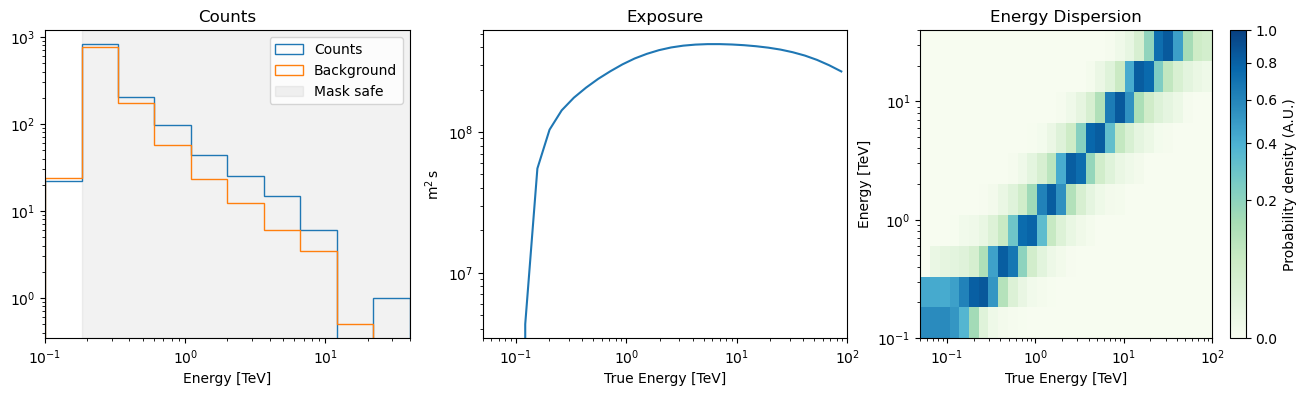

In [11]:
datasets[0].peek()

### Cumulative excess and signficance

Finally, we can look at cumulative significance and number of excesses.
This is done with the `info_table` method of
`~gammapy.datasets.Datasets`.




In [12]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,1216,170.5,4.159464335903991,1045.5,1102.3333333333333,1102.3333333333333,nan,4305868.5,422089728.0,1500.009097360074,1683.0,0.8106617500787742,0.6969957727856566,0.1136659772931176,10,9,wstat,43.26800161601427,2091,9.0,18.0,0.5
stacked,2339,270.5,4.7224642932828935,2068.5,2158.666666666667,2158.666666666667,nan,14651086.0,831744960.0,2997.0830391794443,3366.0,0.7804254901927518,0.6901710673209521,0.09025442287179963,10,9,wstat,72.2340282463576,4137,9.0,18.0,0.5
stacked,3521,480.5,6.880790051412004,3040.5,3200.6666666666665,3200.6666666666665,nan,25027040.0,1240954752.0,4491.585450589657,5048.0,0.7839102781708766,0.6769324625897615,0.10697781558111508,10,9,wstat,121.08402714166986,6081,9.0,18.0,0.5
stacked,4684,653.0,8.11478193157773,4031.0,4248.666666666668,4248.666666666668,nan,29493956.0,1661560064.0,5989.2399297207585,6730.0,0.7820691865684509,0.6730403268696469,0.10902885969880412,10,9,wstat,159.53811351626462,8062,9.0,18.0,0.5
stacked,5895,874.66650390625,9.869911175403269,5020.33349609375,5293.754465997458,5293.754465997458,nan,39191576.0,2070336768.0,7488.240902796386,8413.0,0.7872342886028932,0.6704289513734757,0.11680533722941755,10,9,wstat,214.86274893608885,11030,9.0,19.77358627319336,0.45515263080596924
stacked,6985,993.16650390625,10.25111342275998,5991.83349609375,6305.481315567763,6305.481315567763,nan,41748732.0,2499471872.0,8993.412239596246,10095.0,0.7766796199162763,0.6662469523761929,0.1104326675400835,10,9,wstat,238.19703760223325,12973,9.0,19.48602294921875,0.4618695378303528


And make the correponding plots



Text(0, 0.5, 'Sqrt(TS)')

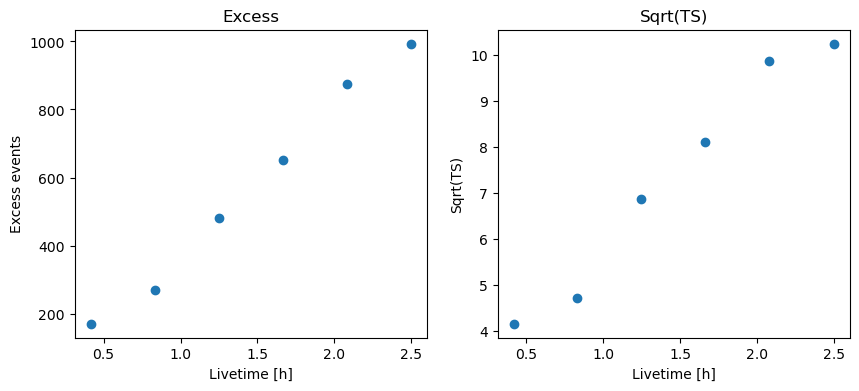

In [13]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)
ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

## Perform spectral model fitting

Here we perform a joint fit.

We first create the model, here a simple powerlaw, and assign it to
every dataset in the `~gammapy.datasets.Datasets`.




In [14]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="RXJ 1713")

datasets.models = [model]

Now we can run the fit




In [15]:
fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 38
	total stat : 52.79

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



### Explore the fit results

First the fitted parameters values and their errors.




In [16]:
display(datasets.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
RXJ 1713,spectral,index,2.1102e+00,,6.129e-02,nan,nan,False,False,
RXJ 1713,spectral,amplitude,1.3576e-11,cm-2 s-1 TeV-1,9.757e-13,nan,nan,False,True,
RXJ 1713,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


Then plot the fit result to compare measured and expected counts. Rather
than plotting them for each individual dataset, we stack all datasets
and plot the fit result on the result.




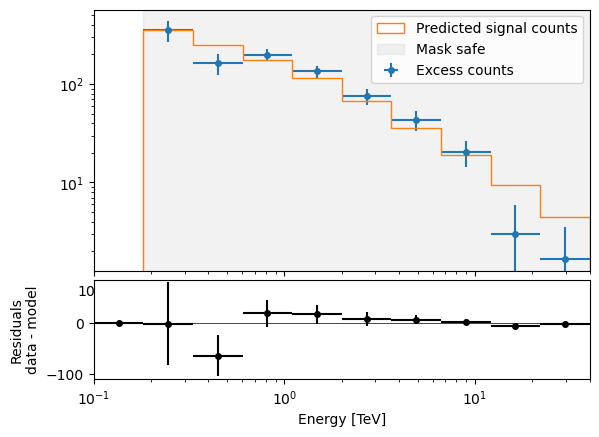

In [17]:
# First stack them all
reduced = datasets.stack_reduce()
# Assign the fitted model
reduced.models = model
# Plot the result

plt.figure()
ax_spectrum, ax_residuals = reduced.plot_fit()
reduced.plot_masks(ax=ax_spectrum)
plt.show()